<a href="https://colab.research.google.com/github/RodrickGulu/Final_Year_Project/blob/main/training_model_with_blurry_image_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Creating dataset and labels for training purposes, while filtering out blurry images....
Done!!
1321 images remaining after filtering out 449 blurry images
80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                      

53/53 [==============================] - 9s 171ms/step - loss: 1.2418 - accuracy: 0.8646 - val_loss: 4.0608 - val_accuracy: 0.6981
Epoch 3/100
53/53 [==============================] - 9s 174ms/step - loss: 0.8070 - accuracy: 0.9062 - val_loss: 3.5315 - val_accuracy: 0.7358
Epoch 4/100
40/53 [=====================>........] - ETA: 1s - loss: 0.5247 - accuracy: 0.9450

53/53 [==============================] - 9s 178ms/step - loss: 0.5518 - accuracy: 0.9384 - val_loss: 4.8439 - val_accuracy: 0.7774
Epoch 5/100
53/53 [==============================] - 9s 179ms/step - loss: 0.9646 - accuracy: 0.9138 - val_loss: 2.2856 - val_accuracy: 0.7849
Epoch 6/100
34/53 [==================>...........] - ETA: 2s - loss: 0.2210 - accuracy: 0.9632

53/53 [==============================] - 10s 181ms/step - loss: 0.3089 - accuracy: 0.9527 - val_loss: 2.7027 - val_accuracy: 0.7849
Epoch 7/100
53/53 [==============================] - 9s 169ms/step - loss: 0.2863 - accuracy: 0.9631 - val_loss: 2.5260 - val_accuracy: 0.8000
Epoch 8/100
28/53 [==============>...............] - ETA: 3s - loss: 0.4319 - accuracy: 0.9643

53/53 [==============================] - 10s 187ms/step - loss: 0.4090 - accuracy: 0.9640 - val_loss: 2.9969 - val_accuracy: 0.7472
Epoch 9/100
53/53 [==============================] - 9s 177ms/step - loss: 0.2447 - accuracy: 0.9725 - val_loss: 3.6200 - val_accuracy: 0.7698
Epoch 10/100
22/53 [===========>..................] - ETA: 4s - loss: 0.1428 - accuracy: 0.9818

53/53 [==============================] - 9s 178ms/step - loss: 0.2819 - accuracy: 0.9735 - val_loss: 2.5666 - val_accuracy: 0.8189
Epoch 11/100
53/53 [==============================] - 10s 189ms/step - loss: 0.2486 - accuracy: 0.9735 - val_loss: 2.6627 - val_accuracy: 0.8113
Epoch 12/100
16/53 [========>.....................] - ETA: 5s - loss: 0.2443 - accuracy: 0.9781

53/53 [==============================] - 9s 170ms/step - loss: 0.3457 - accuracy: 0.9716 - val_loss: 3.4195 - val_accuracy: 0.7925
Epoch 13/100
53/53 [==============================] - 9s 170ms/step - loss: 0.2742 - accuracy: 0.9612 - val_loss: 3.2279 - val_accuracy: 0.8075
Epoch 14/100
10/53 [====>.........................] - ETA: 5s - loss: 0.3238 - accuracy: 0.9600

53/53 [==============================] - 9s 169ms/step - loss: 0.3981 - accuracy: 0.9517 - val_loss: 3.2006 - val_accuracy: 0.8340
Epoch 15/100
53/53 [==============================] - 10s 184ms/step - loss: 0.3767 - accuracy: 0.9602 - val_loss: 5.0717 - val_accuracy: 0.8000
Epoch 16/100
 4/53 [=>............................] - ETA: 6s - loss: 0.7468 - accuracy: 0.9625

53/53 [==============================] - 10s 185ms/step - loss: 0.3174 - accuracy: 0.9678 - val_loss: 4.2754 - val_accuracy: 0.7698
Epoch 17/100
51/53 [===========================>..] - ETA: 0s - loss: 0.5772 - accuracy: 0.9618

53/53 [==============================] - 9s 171ms/step - loss: 0.5575 - accuracy: 0.9631 - val_loss: 3.1153 - val_accuracy: 0.8189
Epoch 18/100
53/53 [==============================] - 10s 187ms/step - loss: 0.2900 - accuracy: 0.9820 - val_loss: 3.6516 - val_accuracy: 0.8038
Epoch 19/100
45/53 [========================>.....] - ETA: 1s - loss: 0.4056 - accuracy: 0.9733

53/53 [==============================] - 10s 187ms/step - loss: 0.3981 - accuracy: 0.9735 - val_loss: 4.0100 - val_accuracy: 0.7736
Epoch 20/100
53/53 [==============================] - 10s 186ms/step - loss: 0.2968 - accuracy: 0.9706 - val_loss: 4.0245 - val_accuracy: 0.7962
Epoch 21/100
39/53 [=====================>........] - ETA: 1s - loss: 0.2528 - accuracy: 0.9821

53/53 [==============================] - 9s 172ms/step - loss: 0.3086 - accuracy: 0.9754 - val_loss: 4.0087 - val_accuracy: 0.8226
Epoch 22/100
53/53 [==============================] - 10s 186ms/step - loss: 0.3105 - accuracy: 0.9839 - val_loss: 3.0631 - val_accuracy: 0.8189
Epoch 23/100
33/53 [=================>............] - ETA: 2s - loss: 0.2935 - accuracy: 0.9864

53/53 [==============================] - 10s 187ms/step - loss: 0.4126 - accuracy: 0.9820 - val_loss: 4.1166 - val_accuracy: 0.8151
Epoch 24/100
53/53 [==============================] - 9s 172ms/step - loss: 0.2963 - accuracy: 0.9839 - val_loss: 3.2529 - val_accuracy: 0.8113
Epoch 24: early stopping
9/9 [==============================] - 6s 310ms/step - loss: 3.2529 - accuracy: 0.8113
Loss: 3.2529115676879883
Accuracy: 0.8113207817077637
9/9 [==============================] - 2s 156ms/step
Accuracy Score: 0.8113207547169812
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       125
           1       0.81      0.84      0.83       140

    accuracy                           0.81       265
   macro avg       0.81      0.81      0.81       265
weighted avg       0.81      0.81      0.81       265

9/9 [==============================] - 1s 157ms/step


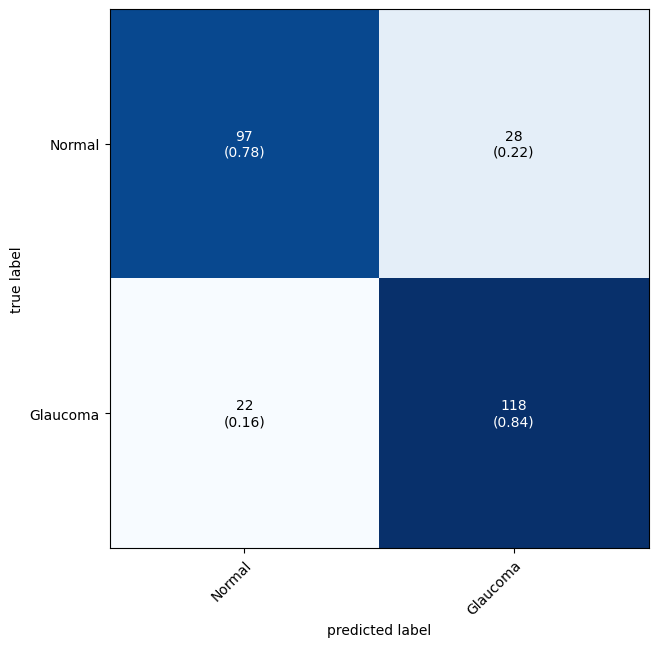

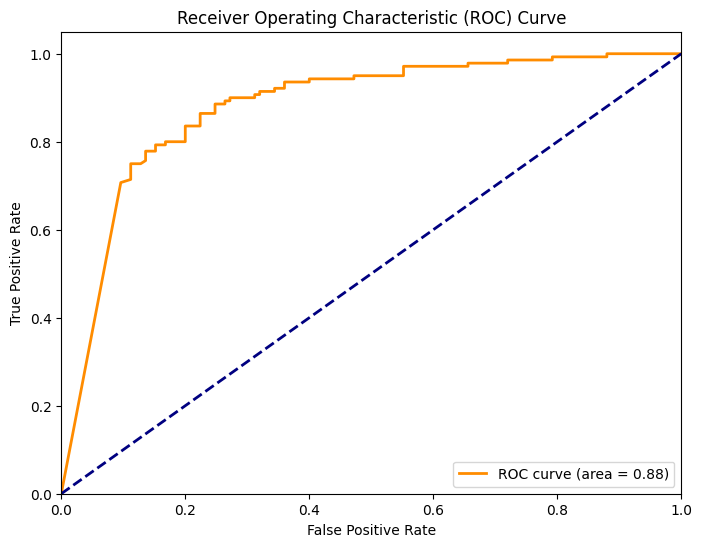

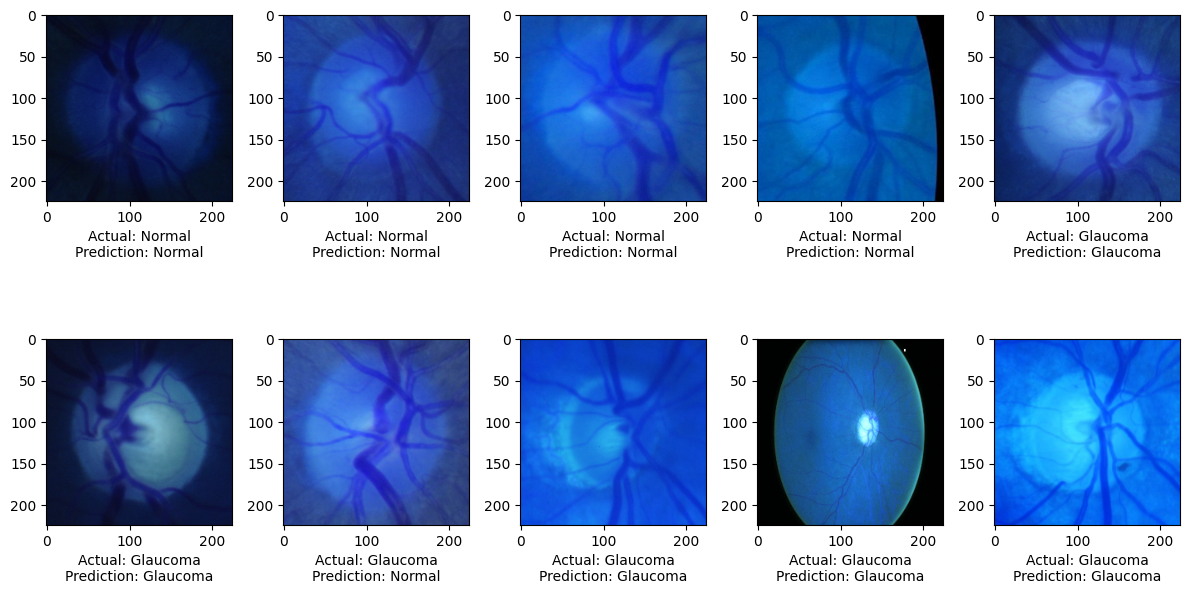

In [3]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import random
from google.colab.patches import cv2_imshow


def load_images_from_folder(folder_path):
    images = []
    labels = []
    blurs=0

    print("Creating dataset and labels for training purposes, while filtering out blurry images....")

    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        label = 1 if folder_name == "glaucoma" else 0

        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))

            # Check for blurry images
            if img is not None:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blur = cv2.Laplacian(gray, cv2.CV_64F).var()
                text="blurry"

                # Set a threshold for blur
                if blur > 20:
                    images.append(img)
                    labels.append(label)
                else:
                  blurs+=1

    print("Done!!")
    return np.array(images), np.array(labels), blurs

# Path to my dataset folder
dataset_path = '/content/drive/MyDrive/glaucoma_dataset/training'

# Load images from the folder
images, labels, blurs = load_images_from_folder(dataset_path)
print(f"{len(images)} images remaining after filtering out {blurs} blurry images")

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


epochs=100
batch_size=20


# Defining the VGG19 model
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg.layers:
    layer.trainable = False

vgg.summary()
#adding my own layers
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1, activation="sigmoid"))
model.summary()

#compiling the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

#defining claabacks
checkpoint = ModelCheckpoint("/content/drive/MyDrive/vgg19_glaucoma_with_filter.keras", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=False, save_freq=epochs)
earlystop = EarlyStopping(monitor="val_accuracy", patience=10, verbose=1)
callbacks=[checkpoint, earlystop]

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test),
                    verbose=1, callbacks=callbacks)

loss, accuracy = model.evaluate(x_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

y_pred = (model.predict(x_test) > 0.5).astype(int)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=cm, figsize=(8, 7), class_names=["Normal", "Glaucoma"], show_normed=True)

y_probs = model.predict(x_test).ravel()

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


#samples images with the predicted and actual label
plt.figure(figsize=(12, 7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    label = "Normal" if category == 0 else "Glaucoma"
    pred_label = "Normal" if pred_category == 0 else "Glaucoma"

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(f"Actual: {label}\nPrediction: {pred_label}")
plt.tight_layout()
plt.show()
